# MODEL 2. ESTIMATION OF TOC BASED ON SOIL PHYSICAL VARIABLES
In this notebook, we will use a Random Forest Regression model to estimate the amount of organic carbon in the soil based on measurable variables such as water content, texture, and bulk density. Our analysis used soil property data from the First Agricultural Soil Condition Survey - Core Dataset (Poeplau et al., 2020), a comprehensive national survey of German agricultural soils.

# 1. Import libraries

In [2]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para el modelo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression


from scipy import stats


In [3]:
ruta = ('data/processed/df_soils.csv') 
df = pd.read_csv(ruta)

In [4]:
lista_variables = list(df.columns)

# 2. Variables selection
## 2.1. Encoding categorical variables

There are too many variables, and not all are necessary for estimating carbon content. To identify the most useful ones, we will use KBest. Before applying this method, we need to encode categorical variables.

In [5]:
variables_categoricas = ['Soil colour', 'Carbonate class','Rooting intensity','Soil texture class_x']

le = LabelEncoder()


for variable in variables_categoricas:
    df[variable + ' encoded'] = le.fit_transform(df[variable])


First, we will remove variables that have been encoded, identifier columns, and those directly related (such as TC or TN), as well as the target variable itself.


In [6]:
columnas_eliminar = ['PointID',
 'HorizontID',
 'Upper limit',
 'Lower limit',
 'Horizon symbol',
 'Soil colour',
 'Stones',
 'Carbonate class',
 'Organic matter content class',
 'Rooting intensity',
 'Soil texture class_x',
 'TC',
 'TOC',
 'TIC',
 'TN',
 'County']

y= df['TOC']

X = df.drop(columns = columnas_eliminar)



## 2.2. Select KBest. 
We use Select KBest to select the top k features from this dataset. This allow us to reduce dimensionality and improve model accuracy. After this we can ask if the model can be used only with physical properties of the soil.

In [7]:
# Create selector and an important features group (X_nuevo)
selector = SelectKBest(score_func=f_regression, k=15)

X_nuevo = selector.fit_transform(X, y)

# Obtain scores and p-values
scores = selector.scores_
pvalues = selector.pvalues_

# Create a Df with the results
resultados = pd.DataFrame({
    'Variable': X.columns,
    'F-score': scores,
    'p-value': pvalues
})

# Filtering selected variables
resultados_filtrados = resultados[selector.get_support()]

# Sort by F-score
resultados_filtrados = resultados_filtrados.sort_values(by='F-score', ascending=False)

print(resultados_filtrados)

                        Variable       F-score        p-value
14                 Water content  68009.128294   0.000000e+00
11                         BD_FS  19151.880865   0.000000e+00
12                       BD_bulk  16491.367876   0.000000e+00
16                        EC_H2O   2469.763080   0.000000e+00
13                           FSS   2211.134835   0.000000e+00
21  Soil texture class_x encoded   1182.962282  9.057863e-251
15                        pH_H2O   1020.202628  1.589976e-217
17                      pH_CaCl2    673.580253  1.053843e-145
0         Rock fragment fraction    150.836155   1.588479e-34
2                             gS     87.927935   7.612699e-21
3                             mS     81.704726   1.744863e-19
20     Rooting intensity encoded     52.091457   5.518602e-13
4                             fS     50.853820   1.034657e-12
5                             gU     50.740433   1.096002e-12
18           Soil colour encoded     38.124504   6.786175e-10


In [8]:
# We can now decide which variables are going to use (F-score > 100)

features = ['Water content','BD_FS','BD_bulk','EC_H2O','FSS','Soil texture class_x encoded','pH_H2O','pH_CaCl2','Rock fragment fraction']

target = 'TOC'

y=df[target]

X = df[features]


## 2.3. Correlation matrix

<Axes: >

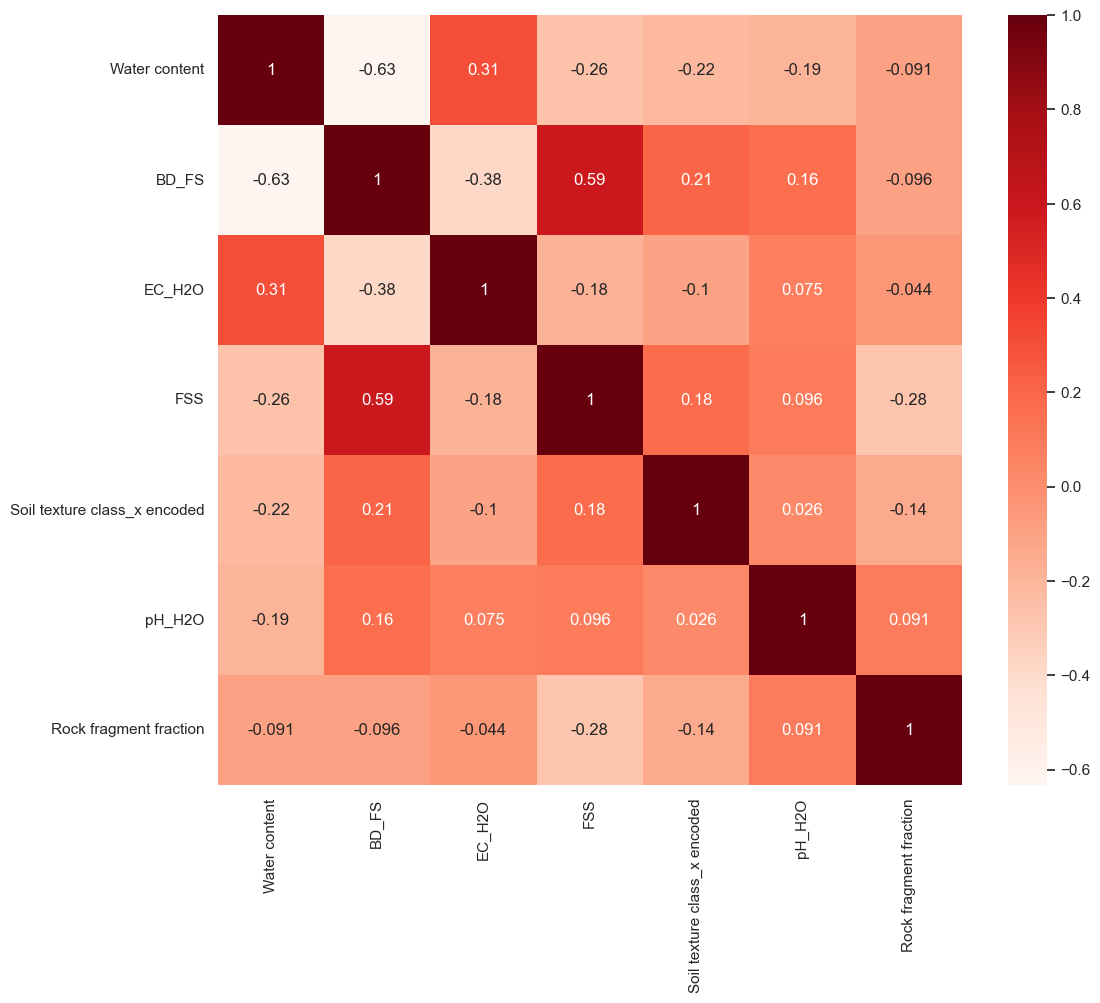

In [50]:
df_features = df[features]

plt.figure(figsize= (12, 10))
cor = df_features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

Thanks to the correlation matrix we can see variables related between them and be able to make decision about.

# 3. TRAIN THE MODEL


In [9]:
# Train and test goups using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [11]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MSE: 149.506
R²: 0.960


It is acceptable MSE value? we will compare the range with the RMSE (Relative Error (%))

In [17]:
maxim = df['TOC'].max()
minim = df['TOC'].min()
range_TOC = maxim - minim
range_TOC

np.float64(582.81)

In [16]:
rmse = np.sqrt(149.5)
rmse

np.float64(12.227019260637483)

In [22]:
error = (rmse / range_TOC) * 100
print(f"The model error is {error:.3f}%")

The model error is 2.098%


It can be assumed that the model predicts TOC accurately using these variables.

# 4. Try to improve the model

## 4.1. Visualizing data 

### 4.1.1 Predicted TOC vs real TOC

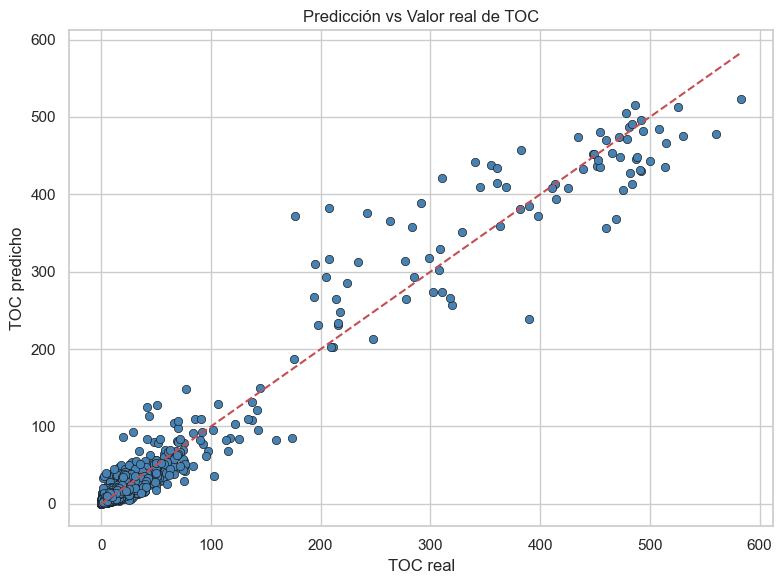

In [24]:
sns.set(style="whitegrid")

# Scatterplot with seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color="steelblue", edgecolor="k")

# Reference line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')

# Titles and labels
plt.title("Predicción vs Valor real de TOC")
plt.xlabel("TOC real")
plt.ylabel("TOC predicho")

plt.tight_layout()
plt.show()

### 4.1.2. Visualizing outlayers 

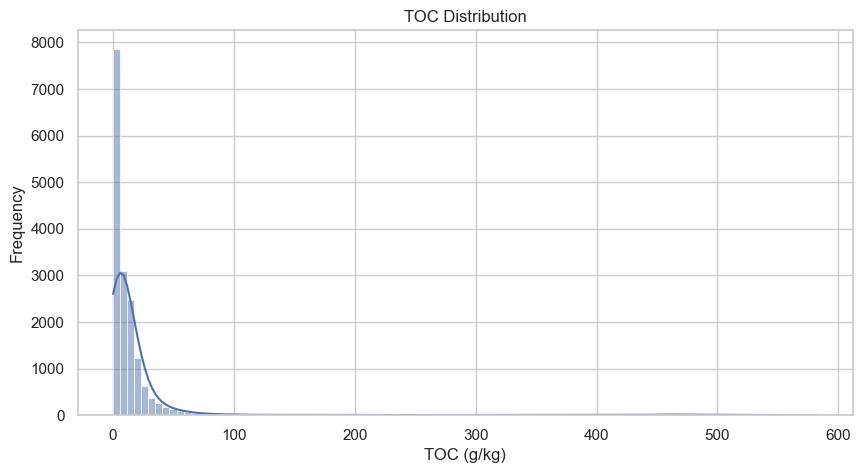

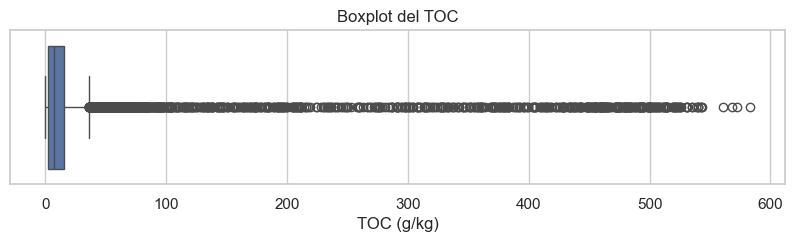

In [27]:
toc_values = df['TOC']

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(toc_values, bins=100, kde=True)
plt.title('TOC Distribution')
plt.xlabel('TOC (g/kg)')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=toc_values)
plt.title('Boxplot del TOC')
plt.xlabel('TOC (g/kg)')
plt.show()


## 4.2. Transformations

### 4.2.1. Logaritmic transformation
We can try a logaritmic transformation to stabilize variance.

In [29]:
df['TOC_log'] = np.log1p(df['TOC'])

In [30]:
# Run the modified model:

features = ['Water content','BD_FS','BD_bulk','EC_H2O','FSS','Soil texture class_x encoded','pH_H2O','pH_CaCl2','Rock fragment fraction']

target_log = 'TOC_log'

y=df[target_log]
X = df[features]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [31]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MSE: 0.193
R²: 0.853


Now MSE is lower but r2 too.
Let's assess the overfitting

In [32]:
# cross validation K-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# define scorers
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)

# Calculate MSE and R2 in each fold
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Results
print(f"Cross-validated MSE (log TOC): {mse_scores.mean():.3f} ± {mse_scores.std():.3f}")
print(f"Cross-validated R² (log TOC): {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")


Cross-validated MSE (log TOC): 0.200 ± 0.006
Cross-validated R² (log TOC): 0.853 ± 0.005


In [30]:
# Now do the k fold with the original dataset:

y=df[target]

X = df[features]

# Cross validationK-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# scorers
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)

# MSE and R2 
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Results
print(f"Cross-validated MSE (log TOC): {mse_scores.mean():.3f} ± {mse_scores.std():.3f}")
print(f"Cross-validated R² (log TOC): {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")


Cross-validated MSE (log TOC): 144.364 ± 22.921
Cross-validated R² (log TOC): 0.966 ± 0.005


### 4.2.2 Eliminating outlayers

In [33]:

# Calculate  Z-score for the column
z_scores = stats.zscore(df['TOC'])

# Umbral deffinition
threshold = 3

# Boolean mask
df_sin_outliers = df[abs(z_scores) < threshold]

# Filtering
df['TOC_outlyers'] = df['TOC'][abs(z_scores) < threshold]

# NaNs processing
df['TOC_outlyers'] = df['TOC_outlyers'].fillna(df['TOC_outlyers'].median())


In [34]:
# Testing the model without outlayers

features = ['Water content','BD_FS','BD_bulk','EC_H2O','FSS','Soil texture class_x encoded','pH_H2O','pH_CaCl2','Rock fragment fraction']

target_out = 'TOC_outlyers'

y=df[target_out]
X = df[features]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [35]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MSE: 143.434
R²: 0.622


This preprocessing step significantly degrades the model's performance.

# 5. Use the model only with physical properties

In [39]:
physical_features = ['Water content','BD_FS','BD_bulk','FSS','Soil texture class_x encoded']

target = 'TOC'

y= df[target]

X = df[physical_features]


In [40]:
# Train and test goups using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [43]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MSE: 211.223
R²: 0.943


# 6. Conclusions:

Logarithmic Transformation
    Applying a logarithmic transformation to TOC values in the RandomForestRegression model reduced the mean squared error (MSE), but also decreased the R² score.

Outlier Removal Impact
    Eliminating outliers resulted in the loss of data points that explain the natural variability of the dataset.

Full Model Performance
    Using all available variables (Water content, BD_FS, BD_bulk, EC_H2O, FSS, Soil texture class_x encoded, pH_H2O, pH_CaCl2, Rock fragment fraction), the model achieved:

    MSE: 149.506
    R²: 0.960
    demonstrating strong predictive capability for soil TOC.

Physical Variables Only
    When using only physical variables (Water content, BD_FS, BD_bulk, FSS, Soil texture class_x encoded):

    MSE: 211.223
    R²: 0.943
    While MSE increases, this simplified approach still provides reasonable TOC estimates while significantly reducing analytical effort and costs.


# References
Poeplau, C., Don, A., Flessa, H., Heidkamp, A., Jacobs, A., Prietz, R., 2020. Erste Bodenzustandserhebung Landwirtschaft – Kerndatensatz. https://doi.org/10.3220/DATA20200203151139